## MNLE inference with varying numbers of trials

This notebook presents are short summary of the code needed to train MNLE on the DDM and then perform inference with MCMC. 

The MNLE code itself and training and mcmc utils can be found in `mnle_utils.py` in this folder. 

If you have any questions please create an issue in the repository.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sbibm
import sbi
import torch

from mnle_utils import BernoulliMN, MNLE, train_choice_net, run_mcmc
from sbi import inference
from sbi.utils import likelihood_nn

# Plotting settings
plt.style.use('plotting_settings.mplstyle')
# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
# Loading DDM simulator and prior from sbibm framework.
task = sbibm.get_task("ddm")
prior = task.get_prior_dist()
simulator = task.get_simulator()

In [3]:
# Generate training data (local Julia installation required) or load from disk.
julia_available = False
N = 100000

if julia_available:
    theta = prior.sample((N,))
    x = simulator(theta)
else:
    with open("../data/ddm_training_data.p", "rb") as fh:
        theta, x, *_ = pickle.load(fh).values()

theta = theta[:N]
x = x[:N]
# The DDM simulator returns choices encoded as sign of the reaction times, decode:
rts = abs(x)
choices = torch.ones_like(x)
choices[x < 0] = 0
# Concatenate theta and choices for conditional flow training below.
theta_and_choices = torch.cat((theta, choices), dim=1)

## Hyperparameters

In [4]:
num_hidden_layers = 3
num_hidden_units = 10
validation_fraction = 0.1
stop_after_epochs = 20
training_batch_size = 100

# for neural spline flow
use_log_rts = True
num_transforms = 2
num_bins = 5
base_distribution = "normal"
tails = "linear"
tail_bound = 10
tail_bound_eps = 1e-7


## Train separate likelihood estimators for choices and reaction times

In [5]:
# train choice net.
choice_net, vallp = train_choice_net(
    theta,
    choices,
    # set up NN to learn Bernoulli probs over choices.
    net=BernoulliMN(
        n_hidden_layers=num_hidden_layers, n_hidden_units=num_hidden_units
    ),
    validation_fraction=validation_fraction,
    stop_after_epochs=stop_after_epochs,
    batch_size=training_batch_size,
)

In [6]:
## train flow using sbi routines.
# construct the density estimator.
density_estimator_fun = likelihood_nn(
    model="nsf",
    num_transforms=num_transforms,
    hidden_features=num_hidden_units,
    num_bins=num_bins,
    base_distribution=base_distribution,
    tails=tails,
    tail_bound=tail_bound,
    tail_bound_eps=tail_bound_eps,
    num_hidden_spline_context_layers=num_hidden_layers,
)

# set up sbi training object.
inference_method = inference.SNLE(
    density_estimator=density_estimator_fun,
    prior=prior,
)
# append data and train
inference_method = inference_method.append_simulations(
    theta=theta_and_choices,
    x=torch.log(rts) if use_log_rts else rts,
    from_round=0,
)
rt_flow = inference_method.train(
    training_batch_size=training_batch_size,
    show_train_summary=False,
    stop_after_epochs=stop_after_epochs,
)

Neural network successfully converged after 128 epochs.


In [7]:
# Combine both trained density estimators into one MNLE
mnle = MNLE(choice_net, rt_flow, use_log_rts=use_log_rts)

## Visualize learned likelihood estimate

In [8]:
l_lower_bound = 1e-7
# Sample random theta from prior.
test_theta = prior.sample((1,))
# Construct test reaction times.
test_data = torch.linspace(-5, 5, 1000)
# Separate rts and choices.
rts = abs(test_data)
cs = torch.ones_like(test_data)
cs[test_data < 0] = 0

mnle_likelihoods = torch.tensor([mnle.log_prob(x=torch.hstack((r.reshape(-1, 1), c.reshape(-1, 1))), 
                                               theta=test_theta)
                                 for r, c in zip(rts, cs)])

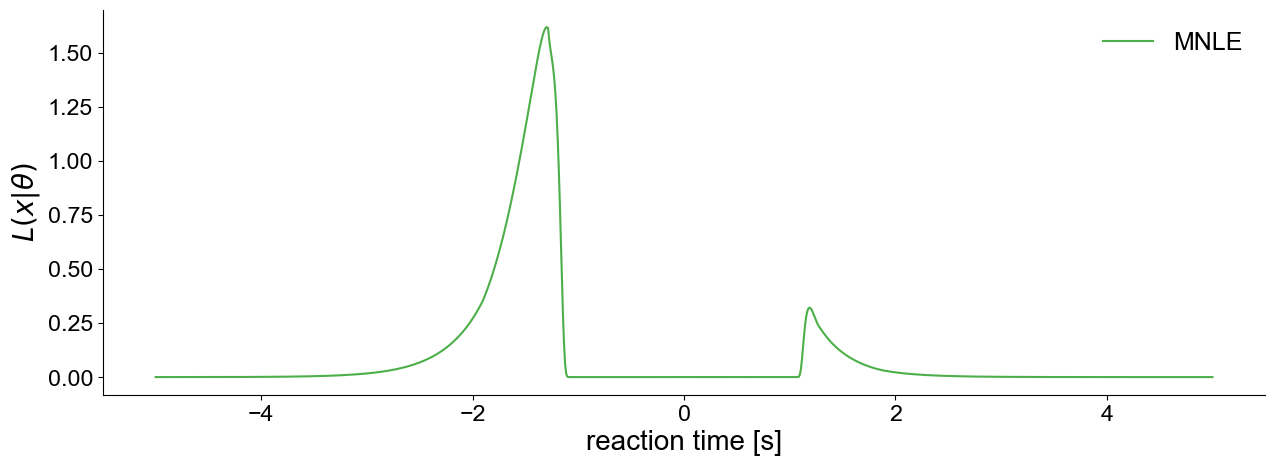

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(test_data, mnle_likelihoods.exp(), label="MNLE", ls="-", c=colors[2]);
plt.ylabel(r"$L(x | \theta)$");
plt.xlabel("reaction time [s]")
plt.legend()
plt.show();

In [10]:
with open("mnle.p", "wb") as fh:
    pickle.dump(dict(mnle=mnle), fh)

## Run inference with MCMC

In [19]:
xo1 = task.get_observation(101)
xo1
xo = torch.zeros(xo1.shape[1], 2)
xo[:, 0] = abs(xo1[0, :])
xo[(xo1 > 0)[0, :], 1] = 1
xo.shape

torch.Size([10, 2])

In [20]:
inference_method._x_shape = xo.shape
posterior = inference_method.build_posterior(density_estimator=mnle)

In [21]:
posterior_samples = posterior.sample((1000,), x=xo)

/Users/Jan/qode/sbi/sbi/utils/sbiutils.py:497: UserWarning: An x with a batch size of 10 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  respect to entire batch, i.e,. p(theta | X)."""
Generating samples: 100%|██████████| 1000/1000 [28:12<00:00,  1.69s/it]


## Visualize posteriors

In [22]:
from sbi.analysis import pairplot

In [23]:
obs = 101  # change to 101 or 201 depending on observation chosen above.
reference_posterior_samples = task.get_reference_posterior_samples(obs)
limits = [[-2, 2], [0.5, 2.0], [.3, .7], [.2, 1.8]]

fig, ax1 = pairplot([reference_posterior_samples, posterior_samples],
         points=sbibm.get_task("ddm").get_true_parameters(obs), 
         limits=limits, 
         ticks=limits, 
         samples_colors=colors[:2], 
         diag="kde",
         upper="contour",
         kde_offdiag=dict(bw_method="scott", bins=50),
         contour_upper=dict(levels=[0.1], percentile=False),
         points_offdiag=dict(marker="+", markersize=10), 
         points_colors=["k"], 
         labels=[r"$v$", r"$a$", r"$w$", r"$\tau$"])

plt.sca(ax1[0, 0])
plt.legend(["Reference", "MNLE", r"Ground truth $\theta$"], 
           bbox_to_anchor=(-.1, -2.2), 
           loc=2)

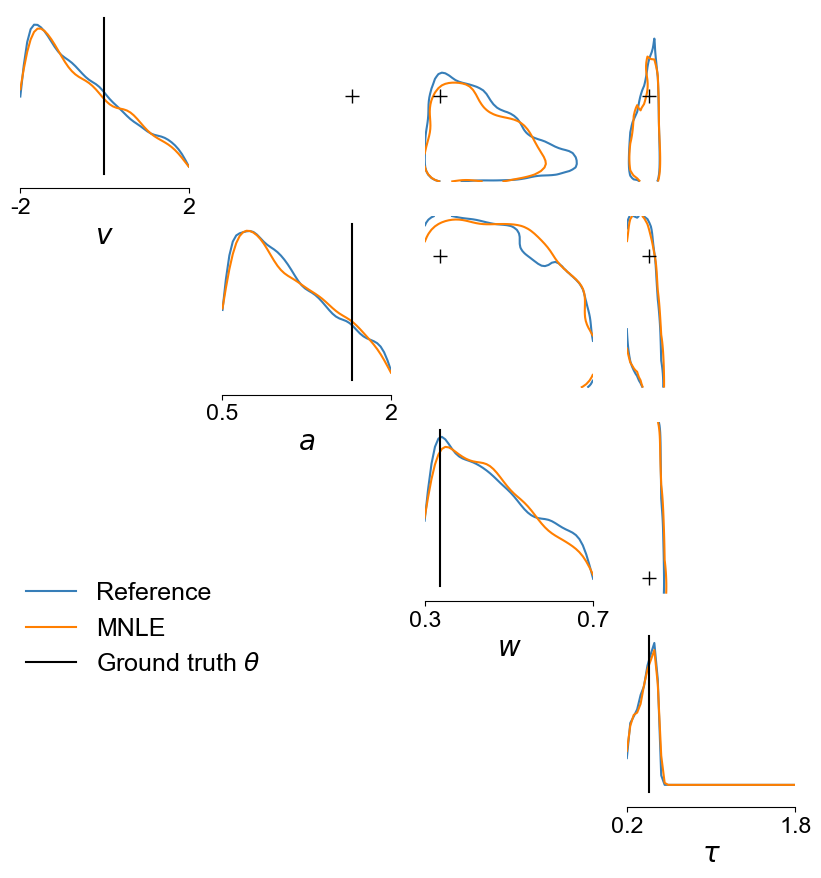

In [18]:
plt.show()